In [225]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.stats as stats

import scipy
import pywt
import mne
from mne.decoding import CSP
import math

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, LeaveOneGroupOut

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder


from mne.time_frequency import AverageTFRArray

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
from stats_utils import *
import glob
import os

from mne.time_frequency import AverageTFRArray
import seaborn as sns
import warnings

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

#warnings and logs
warnings.simplefilter(action='ignore', category=FutureWarning)
mne.set_log_level('CRITICAL')


In [238]:
sub = '02'

ep_file_pre = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_{sub}.fif'
ep_file_post = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_{sub}.fif'


In [242]:
def get_xy_sub(file, label):
    """
    gets the X data and y labels from an epochs object.
    sub: string e.g. '01'

    ---
    returns:
    X: epochs data of shape n_trials x n_channels (64 eeg channels) x n_times
    y: labels of size n_trials. Typically 1 for pre and 2 for post.
    """

    eps = mne.read_epochs(file)
    x = eps.get_data()[:, :64, :] #get eeg channels only
    
    #label array
    y = np.full_like(x[:,0,0], label)
    
    print(x.shape, y.shape)
    return x, y
   

X_pre, y_pre = get_xy_sub(ep_file_pre, 1)

(328, 64, 129) (328,)


(array([[[-1.08573513e-05, -1.11552263e-05, -8.46481635e-06, ...,
          -3.01717478e-06, -5.79369134e-06, -6.65599782e-06],
         [-1.25703682e-05, -1.24210073e-05, -1.09007742e-05, ...,
           6.01847660e-07,  1.90541016e-06, -2.47317780e-06],
         [-8.28460634e-06, -9.25537097e-06, -9.79029119e-06, ...,
          -3.17138210e-06,  8.97655923e-07,  2.41989426e-07],
         ...,
         [-4.34753520e-06, -4.80071276e-06, -6.43968087e-06, ...,
           2.37543190e-06,  2.75932189e-06,  2.71901513e-06],
         [-7.30242800e-06, -7.78520462e-06, -9.64430274e-06, ...,
           2.24939981e-07,  1.88126035e-06,  2.85657620e-06],
         [-6.71416456e-06, -5.64297170e-06, -6.26922338e-06, ...,
           2.56746006e-07,  1.65994834e-06,  2.80687254e-06]],
 
        [[-5.22236678e-06, -4.01742727e-06, -1.78300809e-06, ...,
          -1.63878582e-07,  8.19700688e-07,  1.08672259e-06],
         [ 2.18344121e-06,  3.53333030e-06,  1.89027742e-06, ...,
          -6.73862132

In [226]:
sub = '02'

ep_file_pre = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_{sub}.fif'
eps_pre = mne.read_epochs(ep_file_pre)

ep_file_post = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_{sub}.fif'
eps_post = mne.read_epochs(ep_file_post)


In [227]:
#extract epochs
X1 = eps_pre.get_data()[:,:64,:]

X2 = eps_post.get_data()[:,:64,:]

y_pre = eps_pre.get_data().shape[0]* [1]
y_post = eps_post.get_data().shape[0]*[2]

y = np.hstack([y1, y2])


#PCA
n_PCA = 4
pca = UnsupervisedSpatialFilter(PCA(n_PCA), average=False)
X = np.vstack([X1, X2])
X_pca = pca.fit_transform(X)




#reconstruct PCA into EEG channel space
#X_reconstructed = np.empty_like(X)  # Placeholder for reconstructed data
X_reconstructed = pca.inverse_transform(X_pca)


In [228]:


# PARAMETERS
n_splits = 10  # for cross-validation, 5 is better, here we use 3 for speed
n_components = 4 #components of CSP to keep
#iir_params = dict(order=8, ftype="butter") #for filtering frequencies

# Assemble the classifier using scikit-learn pipeline
clf = make_pipeline(
    CSP(n_components=n_components, reg=None, log=True, norm_trace=False),
    LinearDiscriminantAnalysis(),
)

# CV setup
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) #use logo instead


#cross validation scoring
cross_val_score_freq = cross_val_score(estimator=clf, X=X_reconstructed, y=y, scoring="roc_auc", cv=cv)
print(cross_val_score_freq)

[0.85858586 0.86593205 0.80257117 0.85399449 0.87144169 0.79889807
 0.91287879 0.91477273 0.91856061 0.84375   ]


PCA

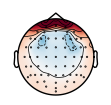

(<matplotlib.image.AxesImage at 0x166538cd0>,
 <matplotlib.contour.QuadContourSet at 0x166538e10>)

In [234]:
pos = eps_pre.info
comp_1 = pca.estimator.components_[3]
mne.viz.plot_topomap(comp_1, pos)


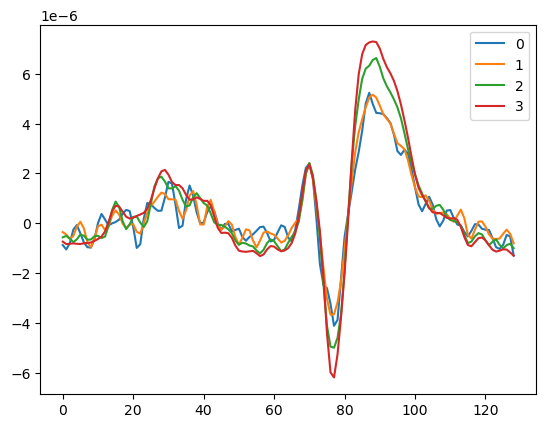

In [230]:
pca_mean = np.mean(X, axis = 0)

for i in range(n_PCA):
    plt.plot(pca_mean[i, :], label = i)

plt.legend()

In [138]:
csp = CSP(n_components=4, reg=None, log=True, transform_into='average_power')

# Fit CSP using labels (e.g., y contains 0/1 for two classes)
csp.fit(X, y)

# Transform the data to extract CSP features
csp_features = csp.transform(X)  # Shape: (n_epochs, n_components)


In [142]:
csp_features.shape

(656, 4)

### Visualize components

In [139]:
ch_names_64, _ = load_channels()
eeg_ch_names = ch_names_64
new_info = mne.pick_info(eps_post.info, sel=[eps_post.info['ch_names'].index(ch) for ch in eeg_ch_names])
csp.plot_patterns(new_info, ch_type="eeg", units="Patterns (AU)", size=1.5)

ValueError: Info (64) and data (4) must have same number of channels.